# 单张图像预训练模型图像分类预测

同济子豪兄

2022-7-16

MMClassification模型库Mode Zoo：https://mmclassification.readthedocs.io/en/latest/model_zoo.html

## 进入 mmclassification 目录

In [3]:
import os
os.chdir('mmclassification')

## 导入工具包

In [24]:
import torch
import mmcv

from PIL import Image

from mmcls.apis import inference_model, init_model, show_result_pyplot

## 准备预训练图像分类模型权重文件

MMClassification模型库中的MobileNet V2图像分类模型：https://github.com/open-mmlab/mmclassification/tree/master/configs/mobilenet_v2

In [5]:
!wget https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth -P checkpoints

--2022-07-16 19:02:56--  https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth
Connecting to 172.16.0.13:5848... connected.
Proxy request sent, awaiting response... 200 OK
Length: 14206911 (14M) [application/octet-stream]
Saving to: ‘checkpoints/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth.1’

mobilenet_v2_batch2 100%[===================>]  13.55M  --.-KB/s    in 0.1s    

2022-07-16 19:02:56 (111 MB/s) - ‘checkpoints/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth.1’ saved [14206911/14206911]



## 载入预训练图像分类模型

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [26]:
# 图像分类模型 config 配置文件
config_file = 'configs/mobilenet_v2/mobilenet_v2_b32x8_imagenet.py'

# 图像分类模型 checkpoint 权重文件
checkpoint_file = 'checkpoints/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth'
# checkpoint_file = 'https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth'

In [27]:
# 通过 config 配置文件 和 checkpoint 权重文件 构建模型
model = init_model(config_file, checkpoint_file, device=device)

load checkpoint from local path: checkpoints/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth


/environment/miniconda3/lib/python3.7/site-packages/mmcv/utils/config.py:236: DeprecationWarning: The config file /home/featurize/work/MMClassification教程/mmclassification/configs/mobilenet_v2/mobilenet_v2_b32x8_imagenet.py will be deprecated in the future. Please use mobilenet-v2_8xb32_in1k.py instead. More information can be found at https://github.com/open-mmlab/mmclassification/pull/508
  warnings.warn(warning_msg, DeprecationWarning)
/home/featurize/work/MMClassification教程/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


In [28]:
model.__class__.__mro__

(mmcls.models.classifiers.image.ImageClassifier,
 mmcls.models.classifiers.base.BaseClassifier,
 mmcv.runner.base_module.BaseModule,
 torch.nn.modules.module.Module,
 object)

## 示例图像

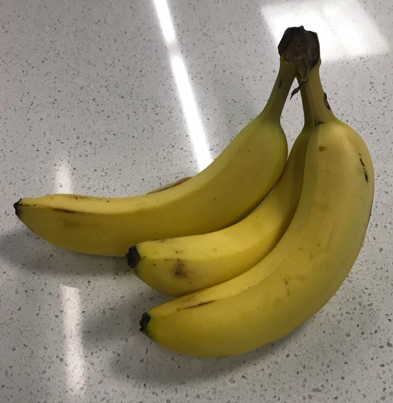

In [25]:
Image.open('data/banana.png')

In [40]:
img = 'data/banana.png'

img_array =  mmcv.imread(img)
result = inference_model(model, img_array)

TypeError: inference_model() got an unexpected keyword argument 'top_k'

In [41]:
inference_model??

Signature: inference_model(model, img)
Source:   
def inference_model(model, img):
    """Inference image(s) with the classifier.

    Args:
        model (nn.Module): The loaded classifier.
        img (str/ndarray): The image filename or loaded image.

    Returns:
        result (dict): The classification results that contains
            `class_name`, `pred_label` and `pred_score`.
    """
    cfg = model.cfg
    device = next(model.parameters()).device  # model device
    # build the data pipeline
    if isinstance(img, str):
        if cfg.data.test.pipeline[0]['type'] != 'LoadImageFromFile':
            cfg.data.test.pipeline.insert(0, dict(type='LoadImageFromFile'))
        data = dict(img_info=dict(filename=img), img_prefix=None)
    else:
        if cfg.data.test.pipeline[0]['type'] == 'LoadImageFromFile':
            cfg.data.test.pipeline.pop(0)
        data = dict(img=img)
    test_pipeline = Compose(cfg.data.test.pipeline)
    data = test_pipeline(data)
    data = collate

In [20]:
result

{'pred_label': 954, 'pred_score': 0.9999288320541382, 'pred_class': 'banana'}

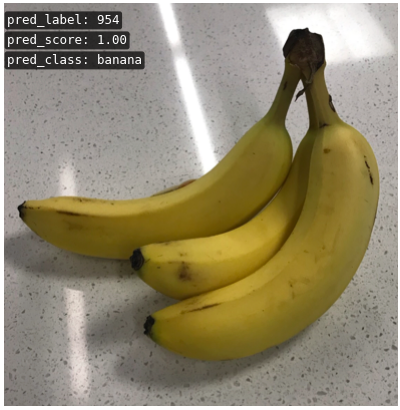

In [21]:
# Show the results
show_result_pyplot(model, img, result)

## 特征抽取

In [29]:
from mmcls.datasets.pipelines import Compose
from mmcv.parallel import collate, scatter

# Pack image info into a dict
data = dict(img_info=dict(filename=img), img_prefix=None)
# Parse the test pipeline
cfg = model.cfg
test_pipeline = Compose(cfg.data.test.pipeline)
# Process the image
data = test_pipeline(data)

# Scatter to specified GPU
data = collate([data], samples_per_gpu=1)
data = scatter(data, [device])[0]

In [36]:
# Forward the model
with torch.no_grad():
    features = model.extract_feat(data['img'])

# Show the feature, it is a 1280-dim vector
print(features[0].shape)

torch.Size([1, 1280])


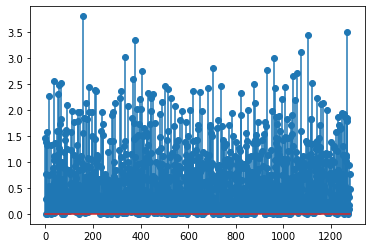

In [39]:
import matplotlib.pyplot as plt
plt.stem(features[0].cpu().numpy().squeeze())
plt.show()